<a href="https://colab.research.google.com/github/liuxx479/cosmo_dep_feedback/blob/master/NN_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
import time

import jax
import jax.numpy as jnp
from jax import jit, grad, random, vmap
from jax.config import config

import tensorflow as tf
import tensorflow_datasets as tfds

import flax.linen as nn
import optax

# from jax.example_libraries import optimizers
# from jax.example_libraries import stax
# from jax.example_libraries.stax import (Dropout, AvgPool, BatchNorm, Conv, Dense, FanInSum,
#                                    FanOut, Flatten, GeneralConv, Identity,
#                                    MaxPool, Relu, LogSoftmax, LeakyRelu)
# from jax.example_libraries.stax import (Tanh, Relu, Exp, LogSoftmax, Softmax, Softplus, Sigmoid, 
#                                    Elu, LeakyRelu, Selu, Gelu)

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

In [28]:
############ colab specific, for mounting google drive
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive'
home = os.path.join(root,'cosmo_dep_feedback/')
### home = '/global/homes/j/jialiu/cosmo_dep_feedback/'

###### the simulation we operate with
isim = 'IllustrisTNG'

### fixed parameters for the simulations: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))

#### this line we get: Omega_m sigma_8 A1 A2 A3 A4
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)

### this line we get: S8=sigma_8*sqrt(omega_m/0.3), fb=omega_b/omega_m, log of [A1 A2 A3 A4]
# labels=['S8', 'fb', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
# lhc_params = concatenate([ [lhc_params[:,1]*sqrt(lhc_params[:,0]/0.3), log10(Omega_b/lhc_params[:,0])], log10(lhc_params[:,2:]).T],axis=0).T


############ load the data from file
kcut=39
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')[:kcut]

Pk_arr = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))[:,:kcut]
Pk_DM_arr = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))[:,:kcut]

r_arr = Pk_arr/Pk_DM_arr
print (r_arr.shape)

lhc_params = concatenate([lhc_params, tile(k, [1000,1])],axis=1)
lhc_params.shape


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1000, 39)


(1000, 45)

In [32]:
lhc_params.shape, r_arr.shape, tile(k, [1000,1]).shape, kcut, k

((1000, 45),
 (1000, 39),
 (1000, 39),
 39,
 array([0.35598565, 0.60316489, 0.85791607, 1.11346431, 1.37403991,
        1.6191547 , 1.87068667, 2.12329004, 2.37814498, 2.63048993,
        2.87865316, 3.13114437, 3.38815958, 3.63874185, 3.88831591,
        4.13905216, 4.39030578, 4.64217234, 4.89467867, 5.14726905,
        5.39800321, 5.64779824, 5.9005343 , 6.1514603 , 6.40263018,
        6.65596467, 6.90878258, 7.15906085, 7.40941476, 7.65922715,
        7.91155947, 8.16375094, 8.41575721, 8.66763884, 8.91880112,
        9.17048011, 9.42056603, 9.67164234, 9.92342616]))

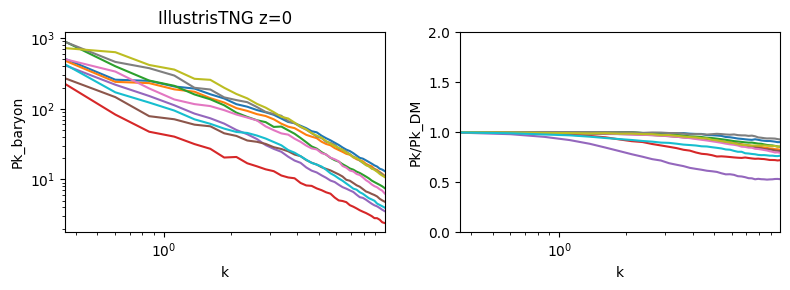

In [29]:
z=0
f, ax=subplots(1,2, figsize=(8,3))

for i in range(10):
    ax[0].plot(k, Pk_arr[i])
    ax[1].plot(k, r_arr[i])
ax[0].set_xlim(k[0], k[-1])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Pk_baryon')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_ylim(0, 2)
ax[1].set_xlim(k[0], k[-1])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()

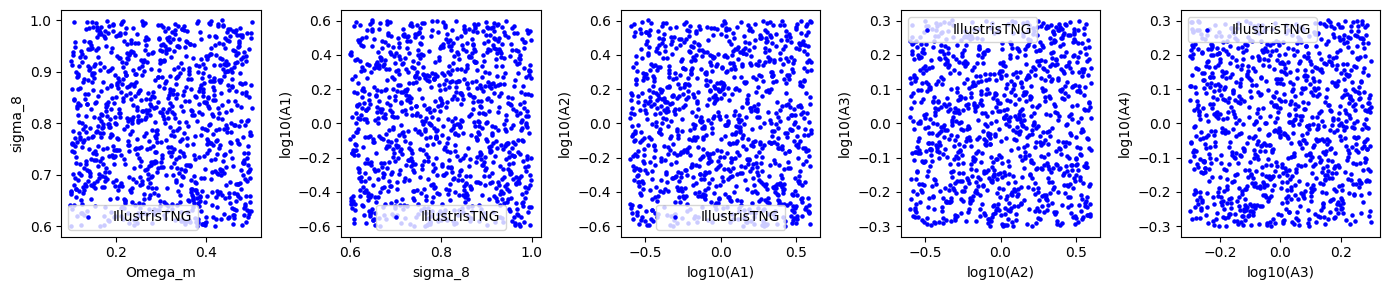

In [30]:
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_params.T[i], lhc_params.T[i+1], color='b', label=isim,s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])   
    ax[i].legend()
plt.tight_layout()
show()

In [31]:
###### we're ready to train a simple NN with these data, first load the numpy array to tensorflow dataset

### data loading following https://jax.readthedocs.io/en/latest/notebooks/neural_network_with_tfds_data.html
# Ensure TF does not see GPU and grab all GPU memory.
# tf.config.set_visible_devices([], device_type='GPU')

dataset = tf.data.Dataset.from_tensor_slices({'r':r_arr, 'cosmo_params':lhc_params})

######### split the dataset to 3 sets: training, validation, test
# num_params = 6
data_size = 1000
batch_size = 64 ### number of maps per batch
valid_size = 128 
test_size = 128
train_size = data_size - valid_size - test_size

### shuffle the dataset so the NN doesn't see the same pattern all the time
shuffle_size = 1000 ### maybe need to shuffle every epoch? oh it's already ON with reshuffle_each_iteration below..

###### now set the batch size for each training cycle, not too small, but smaller than the whole sample of train set
valid_batch = dataset.take(valid_size).batch(valid_size)
test_batch = dataset.skip(valid_size).take(test_size).batch(test_size)
train_batch = dataset.skip(valid_size+test_size).repeat().batch(batch_size)

train_batch.shuffle(shuffle_size, reshuffle_each_iteration=True, seed=0)

############# batch generator
def synth_batches(batch):
  for ibatch in batch:
    yield ibatch['cosmo_params'].numpy(), ibatch['r'].numpy()

batches = synth_batches(train_batch)
batch_valid = next(synth_batches(valid_batch))
batch_test = next(synth_batches(test_batch))

########## quick test
itrain_batch  = next(batches)
print (itrain_batch[0].shape, itrain_batch[1].shape)
print (batch_valid[0].shape, batch_valid[1].shape)
print (batch_test[0].shape, batch_test[1].shape)

(64, 45) (64, 39)
(128, 45) (128, 39)
(128, 45) (128, 39)


In [73]:
class dense_only2(nn.Module):
  @nn.compact
  def __call__(self, x):

    # copied from Francois's example notebook: https://bit.ly/3LaLHq3
    x = nn.leaky_relu(nn.Dense(256)(x))
    x = nn.leaky_relu(nn.Dense(256)(x))
    x = nn.leaky_relu(nn.Dense(256)(x))
    x = nn.leaky_relu(nn.Dense(256)(x))
    # x = nn.leaky_relu(nn.Dense(128)(x))
    # x = nn.leaky_relu(nn.Dense(128)(x))
    # x = nn.leaky_relu(nn.Dense(128)(x))
    # x = nn.leaky_relu(nn.Dense(128)(x))
    
    # Returns the output of the last layer
    x = nn.leaky_relu(nn.Dense(kcut)(x))
    return x

In [85]:
##### define the loss function
def loss_fn(params, x, y, istd=0.05):
  """ Defines the loss function for the model, as a function of model
  parameters `params`, and for a set of inputs/outputs `x` and `y`.
  """
  # Apply the neural network model, and obtain a prediction
  prediction = model.apply(params, x)

  # Compute the loss function for this batch of data
  # In this instance, a simple l2 loss, averaged over the batch
  ivar = istd**2
  return np.mean( (prediction - y)**2 / ivar )

In [86]:
@jax.jit
def update_model(params,  opt_state, x, y):

  # Computes the gradients of the model
  loss, grads = jax.value_and_grad(loss_fn)(params, x, y)

  # Computes the weights updates and apply them
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)

  return params, opt_state, loss

In [87]:
#### set up optimizer and initialize the optimizer
model = dense_only2()
x, y = next(batches)
params = model.init(jax.random.PRNGKey(0), x)

optimizer = optax.adam(learning_rate=step_size)
opt_state = optimizer.init(params)

In [88]:
######## now we train the NN

num_steps = int(train_size/batch_size) ## number of steps per epoch
num_epochs = 1001 #
step_size = 1e-4
epoch0=0

losses = []
# opt_state = opt_init(init_nn_params)

start_time = time.time()
for istep in range(num_epochs * num_steps):
  x, y = next(batches)
  params, opt_state, loss = update_model(params, opt_state, x, y)
  
  epoch = istep/num_steps
  if epoch%1==0:
    epoch_time = (time.time() - start_time)/60.0
    valid_loss = loss_fn(params, batch_valid[0], batch_valid[1])
    losses.append([epoch,loss, valid_loss])
  if epoch%50==0: ####### here for record only
    print("Epoch {} at {:0.2f}m, train loss: {:0.4f}, validation loss: {:0.4f}".format(epoch+epoch0, 
                                                                                       epoch_time, loss, valid_loss))  

Epoch 0.0 at 0.01m, train loss: 175.0589, validation loss: 141.5704
Epoch 50.0 at 0.05m, train loss: 7.1865, validation loss: 7.0388
Epoch 100.0 at 0.09m, train loss: 3.5587, validation loss: 5.2189
Epoch 150.0 at 0.13m, train loss: 0.9219, validation loss: 2.1801
Epoch 200.0 at 0.18m, train loss: 1.8451, validation loss: 1.2733
Epoch 250.0 at 0.23m, train loss: 0.8658, validation loss: 2.2186
Epoch 300.0 at 0.27m, train loss: 0.9908, validation loss: 1.0972
Epoch 350.0 at 0.31m, train loss: 0.7444, validation loss: 0.8556
Epoch 400.0 at 0.34m, train loss: 0.7719, validation loss: 0.8263
Epoch 450.0 at 0.38m, train loss: 0.5517, validation loss: 1.0096
Epoch 500.0 at 0.44m, train loss: 0.7651, validation loss: 0.7727
Epoch 550.0 at 0.48m, train loss: 0.4184, validation loss: 0.7087
Epoch 600.0 at 0.52m, train loss: 0.6681, validation loss: 0.7452
Epoch 650.0 at 0.56m, train loss: 0.7995, validation loss: 0.7562
Epoch 700.0 at 0.60m, train loss: 0.6669, validation loss: 0.8086
Epoch 750

KeyboardInterrupt: ignored

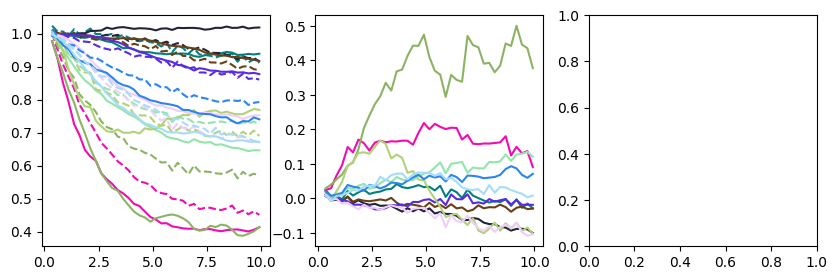

In [84]:
########## plot out the loss vs epoch
epoch_arr,train_loss_arr, valid_loss_arr = np.array(losses).T

########## plot the actual power spectrum

# ibatch = itrain_batch
# ibatch = next(batches)
ibatch = batch_valid
seed(9)
z=0
f, ax=subplots(1,3, figsize=(10,3))

for i in range(10,50):
  icolor=rand(3)
  cosmo_params, r_true = ibatch[0][i], ibatch[1][i]
  r_pred = model.apply(params, cosmo_params)#, rng=key)
  ax[0].plot(k, r_true, color=icolor)
  ax[0].plot(k, r_pred, '--', color=icolor)
  ax[1].plot(k, r_pred/r_true-1, color=icolor)
ax[0].set_xscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('r')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].plot(k, zeros(len(k)),'k--')
ax[1].set_ylim(-0.1, 0.1)
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('$r_{pred}/r_{true}-1$')
ax[1].set_title('solid: truth; dash: predict')

ax[2].plot(epoch_arr, train_loss_arr, label='loss (train)')
ax[2].plot(epoch_arr, valid_loss_arr, label='loss (valid)')
ax[2].legend()
ax[2].set_yscale('log')
ax[2].set_xlabel('epoch')
ax[2].set_ylabel('L2 loss')
ax[2].set_title('Losses')


plt.tight_layout()
show()

In [79]:
cosmo_params.shape

(45,)

**Above we have completed the full NN building and testing, though the NN is not performing well at the moment....**

**Next do bunch of tests to improve the NN**

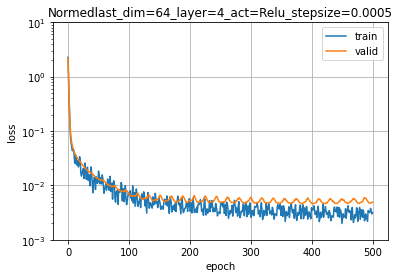

In [ ]:
num_epochs = 500 #50
num_steps = int(train_size/batch_size) ## number of steps per epoch
loss = loss_L2
epoch0=0

########## things to test
num_dense =  64 #256 #64 #
num_layer = 4
step_size = 5e-4 #0.0005 #1e-3
iact=Relu
## # Tanh, Relu, Exp, LogSoftmax, Softmax, Softplus, Sigmoid, Elu, LeakyRelu, Selu, Gelu

##### optimizers
opt_init, opt_update, get_params = optimizers.adam(step_size) ##### seems to work best
# opt_init, opt_update, get_params = optimizers.adagrad(step_size) #### not good
# opt_init, opt_update, get_params = optimizers.sgd(step_size) ### bad
# opt_init, opt_update, get_params = optimizers.nesterov(step_size, mass=0.9) ### bad
# opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=0.9) ## bad

ititle = 'Normedlast_dim=%i_layer=%i_act=Relu_stepsize=%s'%(num_dense, num_layer, step_size)

def dense_only(kcut, num_dense = num_dense):
  return stax.serial(
      Dense(num_params), iact, #BatchNorm(axis=(0,1)),
      Dense(num_dense), iact, #BatchNorm(axis=(0,1)),
      Dense(num_dense), iact, #BatchNorm(axis=(0,1)),
      Dense(num_dense), iact, BatchNorm(axis=(0,1)),
      Dense(kcut)
      )
  
nn_init, nn_apply = dense_only(kcut)

def loss_L2(nn_params, batch, key):
  cosmo_params, r_true = batch
  r_pred = nn_apply(nn_params, cosmo_params, rng=key)
  # L2 = np.mean((r_pred - r_true)**2)
  L2 = np.mean((r_pred/r_true-1)**2)
  return L2

net_out_shape, init_nn_params = nn_init (key, (-1,) + itrain_batch[0].shape[1:])

@jit
def update(i, opt_state, batch, key):
  temp_nn_params = get_params(opt_state)
  return opt_update(i, grad(loss)(temp_nn_params, batch, key), opt_state)

######## now we train the NN
losses = []
opt_state = opt_init(init_nn_params)

start_time = time.time()
for istep in range(num_epochs * num_steps):
  # for istep in range(num_steps):
  key, subkey = random.split(key)  
  this_batch=next(batches)
  opt_state = update(istep, opt_state, this_batch, subkey)
  
  epoch = istep/num_steps
  if epoch%1==0:
    epoch_time = (time.time() - start_time)/60.0
    temp_nn_params = get_params(opt_state)
    train_loss = loss(temp_nn_params, this_batch, subkey)
    valid_loss = loss(temp_nn_params, batch_valid, subkey)
    losses.append([epoch,train_loss, valid_loss])

##  Paco's code: https://github.com/franciscovillaescusa/Pylians3_ML/blob/master/Examples/1D_to_1D/architecture.py
########## plot out the loss vs epoch
epoch_arr,train_loss_arr, valid_loss_arr = np.array(losses).T

f, ax=subplots(1,1)
ax.plot(epoch_arr, train_loss_arr, label='train')
ax.plot(epoch_arr, valid_loss_arr, label='valid')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title(ititle)
ax.set_ylim(1e-3, 10)
plt.grid()
f.savefig(home+'plots/'+ititle+'.jpg')
show()
   

In [ ]:
# !mkdir /content/drive/My\ Drive/cosmo_dep_feedback/plots

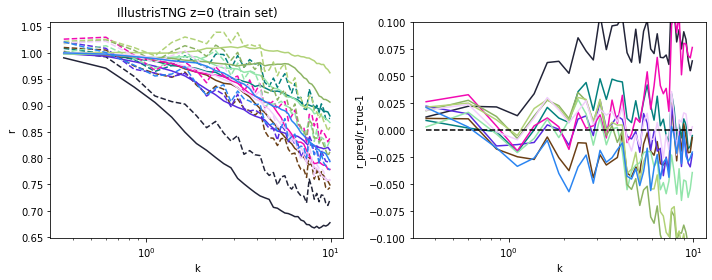

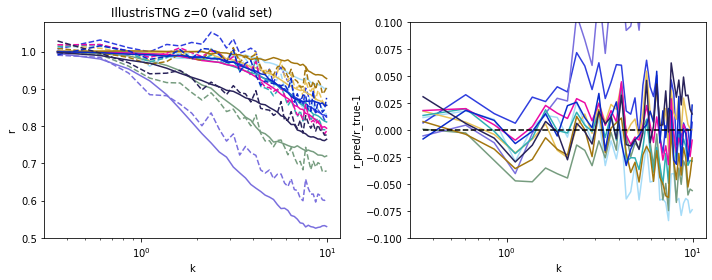

In [ ]:
final_nn_params = get_params(opt_state)

seed(9)
j=0
for ibatch in (next(batches), batch_valid):

  f, ax=subplots(1,2, figsize=(10,4))

  cosmo_params, r_true_arr = ibatch[0], ibatch[1]
  r_pred_arr = np.array(nn_apply(temp_nn_params, cosmo_params))

  ititle='%s z=%i (%s)'%(isim,z, ['train set', 'valid set'][j])
  for i in range(10):
    icolor=rand(3)  
    r_pred=r_pred_arr[i]
    r_true=r_true_arr[i]
    ax[0].plot(k, r_true, color=icolor)
    ax[0].plot(k, r_pred, '--', color=icolor)
    ax[1].plot(k, r_pred/r_true-1, color=icolor)
  ax[0].set_xscale('log')
  ax[0].set_xlabel('k')
  ax[0].set_ylabel('r')
  ax[0].set_title(ititle)
  ax[1].plot(k, zeros(len(k)),'k--')

  ax[1].set_ylim(-0.1, 0.1)
  ax[1].set_xscale('log')
  ax[1].set_xlabel('k')
  ax[1].set_ylabel('r_pred/r_true-1')
  plt.tight_layout()
  show()
  j+=1

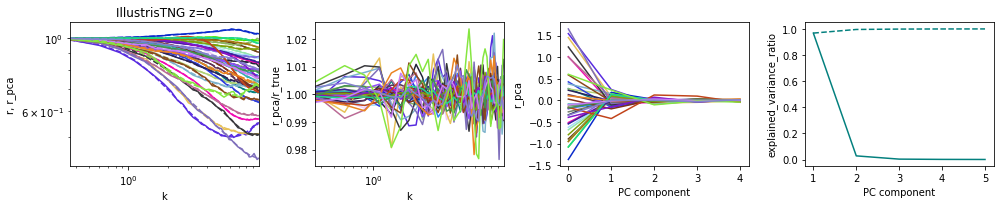

In [ ]:
### try a few things (1) PCA; (2) weight decay; (3) dropouts
from sklearn.decomposition import PCA

seed(9)
icolor=rand(3)

ncomp=5
pca = PCA(n_components=ncomp)
pca.fit(r_arr[:train_size])
x=arange(1,ncomp+1)
evr=pca.explained_variance_ratio_


r_pca=pca.transform(r_arr)
r_inverse = pca.inverse_transform(r_pca)

f, ax=subplots(1,4, figsize=(14,3))
seed(9)

ax[3].plot(x, evr, '-', color=icolor,label='%i components'%(ncomp))
ax[3].plot(x, np.cumsum(evr), '--', color=icolor)
ax[3].set_xlabel('PC component')
ax[3].set_ylabel('explained_variance_ratio')
ax[2].set_xlabel('PC component')
ax[2].set_ylabel('r_pca')

for i in arange(train_size, train_size+40):
  icolor=rand(3)
  # print (i)
  ax[0].plot(k, r_arr[i], color=icolor)
  ax[0].plot(k, r_inverse[i], '--', color=icolor)
  ax[1].plot(k, r_inverse[i]/r_arr[i], color=icolor)
  ax[2].plot(r_pca[i], color=icolor)
ax[0].set_xlim(k[0], k[-1])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('r, r_pca')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_xlim(k[0], k[-1])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('r_pca/r_true')
plt.tight_layout()
show()